In [2]:
%load_ext autoreload
%autoreload 2

I've been meaning to do this test for awhile. I want to see if wavelet scattering networks really decompose kappa maps in the ways I believe they will. 

In [3]:
from kymatio import Scattering2D

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
import torch

In [5]:
import h5py

In [6]:
from scipy.linalg import norm

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

In [8]:
%%bash 
ls ../data/*.hdf5

../data/snd2.samples.hdf5
../data/snd3.samples.hdf5
../data/snd4.samples.hdf5
../data/snd_attacked.samples.hdf5
../data/snd.samples.hdf5
../data/UatuLightconeAttacked.hdf5
../data/UatuLightconePredsAdvShuffleAttack.hdf5
../data/UatuLightconePreds.hdf5
../data/UatuLightconePredsShuffleAttack.hdf5
../data/UatuLightconeSameSeed.hdf5
../data/UatuLightconeTest.hdf5
../data/UatuLightconeTraining.hdf5


In [9]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')

In [10]:
for key in f.keys():
    print(f[key]['Y'][0, :].squeeze() )

[0.334935 0.936993]
[0.312901 0.905159]
[0.256755 0.77129 ]
[0.350059 0.946085]
[0.324626 0.901106]


In [11]:
X = f['Box002']['X'][()].squeeze()

In [12]:
scattering = Scattering2D(J=2, shape=(256,256), max_order=2)

In [13]:
scattering.cuda()

In [14]:
from scipy.spatial.distance import cdist as dist
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [15]:
L = 8
J = 2
K = 1 + L*J#+ (L**2)*(J*(J-1))/2.0
print(K)

17


In [17]:
key = 'Box000'
X = f[key]['X'][164].squeeze()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [30]:
from scipy.fftpack import fft2, fftshift

In [31]:
f = fftshift(fft2(X))

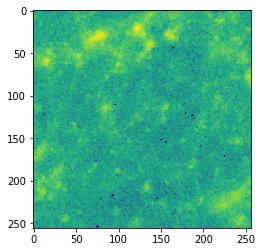

In [32]:
plt.imshow(X)

In [33]:
f.real

array([[ 33.95882624,   1.87299774, -37.14179756, ...,   9.32975226,
        -37.14179756,   1.87299774],
       [-18.78581369,  -0.6742101 ,  -3.97221632, ...,   8.14030317,
          8.77823188, -24.07941061],
       [ -4.99623208,   7.18575008, -30.73788421, ...,  -5.23235298,
          8.20955246,  17.83286705],
       ...,
       [-32.30619431, -10.87682674,  66.83666517, ..., -19.3495479 ,
          4.61312409,  42.71808493],
       [ -4.99623208,  17.83286705,   8.20955246, ..., -18.86779303,
        -30.73788421,   7.18575008],
       [-18.78581369, -24.07941061,   8.77823188, ...,   2.48131558,
         -3.97221632,  -0.6742101 ]])

In [36]:
import matplotlib.colors as colors

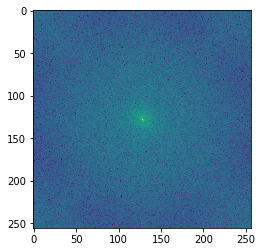

In [39]:
im = plt.imshow(np.absolute(f), norm=colors.LogNorm())
#plt.colorbar(im)

In [45]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [46]:
from scipy import fftpack
def image_ps(image):
  
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)

    return psd1D

[]

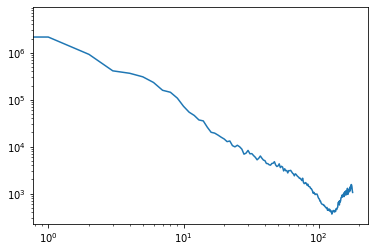

In [49]:
plt.plot(image_ps(X))
plt.loglog();

In [ ]:
xs.shape

In [ ]:
sort_idxs = np.argsort(ys, axis = 0)[:,0]#, key = lambda x: x[0])

In [ ]:
xs = xs[sort_idxs]
ys = ys[sort_idxs]
scatterings = scatterings[sort_idxs]

In [ ]:
x_dists = np.zeros((xs.shape[0], xs.shape[0]))
s_dists = np.zeros((xs.shape[0], xs.shape[0]))
y_dists = np.zeros((xs.shape[0], xs.shape[0]))

for i, (x1, y1, s1) in enumerate(zip(xs, ys, scatterings)):
    for j, (x2, y2, s2) in enumerate(zip(xs, ys, scatterings)):
        if j > i:
            continue
        #print(i,j)
        x_dists[i,j] = x_dists[j,i] = norm(x1-x2)
        y_dists[i,j] = y_dists[j,i] = np.abs(y1[0] - y2[0])#norm(y1-y2)
        s_dists[i,j] = s_dists[j,i] = norm(s1-s2)
        
x_dists/=np.max(x_dists)
s_dists/= np.max(s_dists)
y_dists/=np.max(y_dists)

In [ ]:
xim = plt.imshow(x_dists)
plt.colorbar(xim)

In [ ]:
sim = plt.imshow(s_dists)
plt.colorbar(sim)

In [ ]:
plt.scatter(y_dists.flatten(), x_dists.flatten(), label = 'Images', alpha = 0.3)
plt.scatter(y_dists.flatten(), s_dists.flatten(), label = 'Wavelets', alpha = 0.3)
plt.legend(loc = 'best')
plt.xlabel(r'$\Omega_m$ distance (noramlized)');
plt.ylabel(r'Distance (noramlized)');
plt.title('Diff Seed Boxes');

In [ ]:
plt.scatter(x_axis, )

In [ ]:
norm(X2.cpu() - X.cpu())

In [ ]:
norm(s2-s)

J=1,L = 8, max_order=1

1- 1 diff idx: 46.449482

1 - 2 Same idx: 28.12376

1 -2 Diff idx: 45.11661

2 -2 diff idx: 39.93927

J=2,L = 8, max_order=1

1- 1 diff idx: 18.097593

1 - 2 Same idx: 10.822394

1 -2 Diff idx: 20.753729

2 -2 diff idx: 21.312572


J=2,L = 8, max_order=2

1- 1 diff idx: 18.166098

1 -2 Same idx: 10.9453745

1 -2 Diff idx: 20.818296

2 -2 diff idx: 21.37197
